Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [2]:
NAME = " Piotr Szuba"

---

# 2. Model TNC

Przedstawimy teraz zasadę działania modelu TNC, zaimplementujemy jego  najistotniejsze elementy oraz dokonamy ewaluacji modelu.

## 2.1. Idea modelu TNC
Dla ciągu czasowego $X \in \mathbb{R}^{D \times T}$ możemy określić okno przesuwne $X_{[t - \frac{\delta}{2}, t + \frac{\delta}{2}]}$ o długości $\delta$ wycentrowane wokół chwili $t$, które zawiera pomiary wszystkich cech w przedziale czasu $[t - \frac{\delta}{2}, t + \frac{\delta}{2}]$. Dla ułatwienia zapisu okno to będzie oznaczane jako $W_t$.

Celem metody uczenia reprezentacji będzie uzyskanie wektorowej reprezentacji dowolnego okna $W_t$.

### Temporalne sąsiedztwo
Dla okna $W_t$ zdefiniujmy jego temporalne sąsiedztwo $N_t$ jako zbiór wszystkich okien wycentrowanych w $t^*$, gdzie wartość ta jest próbkowana z rozkładu normalnego $t^* \sim \mathcal{N}(t, \eta \cdot \delta)$. Parametr $\eta$ definiuje szerokość / zakres sąsiedztwa temporalnego.

Wybór parametru $\eta$ może być oparty o wiedzę ekspercką, jednak w publikacji autorzy zaproponowali zastosowanie testu statystycznego **Augmented Dickey-Fuller (ADF)**, który będzie sprawdzać stacjonarność rozkładu próbek w sąsiedztwie temporalnym. Algorytm wyboru parametru zakłada, że rozpoczynamy od niewielkiej wartości, po czym iteracyjnie zwiększamy parametr $\eta$, powodując poszerzenie się temporalnego sąsiedztwa. Zwiększanie wartości następuje do momentu aż test statystyczny nie będzie w stanie odrzucić hipotezy zerowej.


### "Uczenie kontrastowe"
Okna w sąsiedztwie temporalnym możemy uznać jako podobne do obecnie rozważanego okna ciągu czasowego. Pozostaje zatem pytanie jak uzyskać przykłady negatywne, tak abyśmy mogli zastosować koncepcję uczenia kontrastowego. 

Moglibyśmy założyć, że wszystkie próbki (okna) poza temporalnym sąsiedztwem są przykładami negatywnymi. Może się jednak tak zdarzyć, że nawet bardzo odległe okno, jest w istocie podobne do obecnego (ma taką samą dynamikę zmian / pochodzi z tego samego rozkładu). W takiej sytuacji uczenie modelu nie byłoby efektywne. Autorzy proponują użycie podejścia **Positive-Unlabeled (PU) learning**, w którym mamy próbki bazowe, próbki pozytywne i próbki nieoznaczone. W naszym przykładzie próbkami nieoznaczonymi będą próbki spoza sąsiedztwa temporalnego.

Do próbek nieoznaczonych są przypisywane wagi $w$ (tutaj: hiperparametr metody), a każda próbka nieoznaczona jest traktowana jako połączenie próbki pozytywnej z wagą $w$ oraz próbki negatywnej z wagą $1 - w$. Zobaczymy to dalej w funkcji kosztu.

### Koder i dyskryminator
Model TNC będziemy uczyć za pomocą funkcji kosztu, która pozwala odróżniać reprezentacje próbek z tego samego sąsiedztwa temporalnego od próbek spoza sąsiedztwa.

Pierwszym elementem modelu TNC jest **koder** $\text{Enc}(W_t)$, które przekształca okno $W_t \in \mathbb{R}^{D \times \delta}$ w wektor reprezentacji $Z_t \in \mathbb{R}^M$.

Drugim elementem jest **dyskryminator** $\mathcal{D}(Z_t, Z)$ pozwalający aproksymować prawdopodobieństwo tego, że $Z$ jest reprezentacją okna w sąsiedztwie $N_t$. Innymi słowy, dla dwóch wektorów reprezentacji zwraca pradopodobieństwo tego, że te wektory (okna) należą do tego samego sąsiedztwa temporalnego.

Przeanalizujmy rysunek przedstawiający zasadę działania modelu TNC:

![](./assets/tnc.png)

### Funkcja kosztu
W najlepszym przypadku dyskryminator powinien zwracać wartości bliskie 1 dla reprezentacji z tego samego temporalnego sąsiedztwa oraz wartość 0 w przeciwnym przypadku. Funkcja kosztu jest zdefiniowana następująco:

$$\mathcal{L} = -\mathbb{E}_{W_t\sim X}\left[ \mathbb{E}_{W_l \sim N_t}[\log \mathcal{D}(Z_t,Z_l)] +\mathbb{E}_{W_k \sim \bar{N}_t}[(1-w_t)\times \log(1 - \mathcal{D}(Z_t, Z_k)) + w_t\times \log\mathcal{D}(Z_t, Z_k)] \right]$$

## 2.2. Implementacja kodera
Ze względu na sekwencyjny charakter próbek w oknie, jako model kodera użyjemy dwukierunkowej sieci rekurencyjnego typu GRU, która na wyjściu cechy przekształci dodatkową warstwą liniową.

## Zadanie 2.2 (3 pkt)
Zaimplementuj klasę `GRUEncoder` zgodnie z poniższymi wymaganiami:
- w metodzie `__init__()`:
  * utwórz instancję sieci GRU o wymiarze wejściowym `in_dim`, wymiarze ukrytym `hidden_dim`, która posiada jedną warstwę oraz jest dwukierunkowa (ustaw dodatkowo parametr `batch_first=False`)
  * utwórz instancję warstwy liniowej o odpowiednim wymiarze wejściowym oraz wyjściu o wymiarowości `emb_dim`
- w metodzie `_get_initial_hidden()` utwórz wektor zer jako początkowy stan ukryty
- w metodzie `forward()` przetwórz cechy okień podanych na wejściu i wyznacz wektory reprezentacji (używając sieci GRU a następnie warstwy liniowej)

In [3]:
import torch
from torch import nn


class GRUEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, emb_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim

        # TU WPISZ KOD
        raise NotImplementedError()
        
    def _get_initial_hidden(self, batch_size):
        # TU WPISZ KOD
        raise NotImplementedError()

    def forward(self, x):
        x = x.permute(2, 0, 1)
        
        emb = ...
        # TU WPISZ KOD
        raise NotImplementedError()
        
        return emb


In [4]:
import torch
from torch import nn


class GRUEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, emb_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim

        self.gru = nn.GRU(input_size=in_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=False)
        self.linear = nn.Linear(in_features=hidden_dim*4, out_features=emb_dim)

    def _get_initial_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_dim)

    def forward(self, x):
        x = x.permute(2, 0, 1)

        h0 = self._get_initial_hidden(x.size(1))
        out, _ = self.gru(x, h0)

        out = torch.cat((out[-1,:,:], out[0,:,:]), dim=1)
        emb = self.linear(out)
        
        return emb

## 2.3. Implementacja dyskryminatora
Jako dyskryminatora użyjemy prostego dwuwarstwowego perceptrona, tak aby nie ryzykować przeuczeniem tego komponentu.

## Zadanie 2.3 (2 pkt)
Zaimplementuj model dyskryminatora zgodnie z następującymi wymaganiami:
- w metodzie `__init__()` utwórz wielowarstwowy perceptron z następującymi warstwami (`d` to wymiar wejściowy):
  * warstwa liniowa o rozmiarach 2*d na 4*d
  * aktywacja ReLU
  * dropout z prawdp. równym 0.5
  * kolejna warstwa liniowa o rozmiarze 4*d na 1 
- w metodzie `forward()` dokonaj konkatenacji reprezentacji `z` oraz `z_tilde` a następnie przekaż je do perceptrona
  

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # TU WPISZ KOD
        raise NotImplementedError()

    def forward(self, z, z_tilde):
        p = ...
        # TU WPISZ KOD
        raise NotImplementedError()
        
        return p.view((-1,))


In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(2*input_dim, 4*input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4*input_dim, 1),
        )

    def forward(self, z, z_tilde):
        z_concat = torch.cat((z, z_tilde), dim=1)
        p = self.discriminator(z_concat)
        
        return p.view((-1,))

## 2.4. Implementacja funkcji kosztu
W celu implementacji funkcji kosztu możemy wspomóc się gotową funkcją binarnej entropii krzyżowej, zauważając że problem uczenia dyskryminatora (a zatem całego modelu TNC) sprowadza się do problemu klasyfikacji binarnej.

## Zadanie 2.4 (6 pkt)
Zaimplementuj moduł implementujący funkcję kosztu modelu TNC stosując następujące wskazówki/instrukcje:
- `z_t` to reprezentacje obecnie rozważanych okien, `z_p` to reprezentacje pozytywne, natomiast `z_n` to reprezentacje nieoznaczone
- najpierw wyznacz predykcje dyskryminatora dla pary `(z_t, z_p)` oraz `(z_t, z_n)`
- przygotuj etykiety (zera i jedynki) dla par podobnych oraz różnych
- oblicz funkcję binarnej entropii krzyżowej dla wyników dyskryminatora, pamiętaj, że:
  * parę `(z_t, z_p)` chcemy traktować jako pozytywną (klasa 1)
  * parę `(z_t, z_n)` chcemy traktować jako pozytywną z wagą `w` oraz jako negatywną (klasa 0) z wagą `1 - w`
- zaimplementuj metodę `_compute_accuracy()`, która sprawdzi czy decyzje dyskryminatora są właściwe (pary pozytywne mają prawdp. `> 0.5`, a pary negatwne `< 0.5`; pamiętaj o zastosowaniu funkcji sigmoid!); wyniki uśrednij uzyskując miarę accuracy

In [7]:
from typing import Tuple


class TNCLossFunction(nn.Module):

    def __init__(self, emb_dim: int, w: float):
        super().__init__()

        self.discriminator = Discriminator(input_dim=emb_dim)
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.w = w

    def forward(
        self,
        z_t: torch.Tensor,
        z_p: torch.Tensor,
        z_n: torch.Tensor,
    ) -> Tuple[torch.Tensor, float]:
        d_p = ...
        d_n = ...
        loss = ...
        
        # TU WPISZ KOD
        raise NotImplementedError()
        
        accuracy = self._compute_accuracy(d_p=d_p, d_n=d_n)
        
        return loss, accuracy

    @staticmethod
    def _compute_accuracy(d_p: torch.Tensor, d_n: torch.Tensor) -> float:
        # TU WPISZ KOD
        raise NotImplementedError()
        
        return acc


In [8]:
from typing import Tuple

class TNCLossFunction(nn.Module):

    def __init__(self, emb_dim: int, w: float):
        super().__init__()

        self.discriminator = Discriminator(input_dim=emb_dim)
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.w = w

    def forward(
        self,
        z_t: torch.Tensor,
        z_p: torch.Tensor,
        z_n: torch.Tensor,
    ) -> Tuple[torch.Tensor, float]:
        d_p = self.discriminator(z_t, z_p)
        d_n = self.discriminator(z_t, z_n)

        y_p = torch.ones_like(d_p)
        y_n = torch.zeros_like(d_n)

        loss_p = self.bce(d_p, y_p)
        loss_n = self.w * self.bce(d_n, y_p) + (1 - self.w) * self.bce(d_n, y_n)
        loss = loss_p + loss_n
    
        accuracy = self._compute_accuracy(d_p=d_p, d_n=d_n)
        
        return loss, accuracy

    @staticmethod
    def _compute_accuracy(d_p: torch.Tensor, d_n: torch.Tensor) -> float:
        d_p = torch.sigmoid(d_p)
        d_n = torch.sigmoid(d_n)
        
        acc_p = (d_p > 0.5).float().mean().item()
        acc_n = (d_n < 0.5).float().mean().item()
        
        acc = 0.5 * (acc_p + acc_n)
        
        return acc

## 2.5. Uruchomienie modelu TNC
Poniżej znajduje się kod pozwalający wyuczyć model TNC (implementacja w bibliotece PyTorch-Lightning). Ustawimy domyślny zbiór hiperparametrów i będziemy uczyć model przez 50 epok. Następnie zwizualizujemy otrzymane wektory reprezentacji i zastosujemy je w zadaniu klasyfikacji.

Moduł danych:

In [9]:
import os

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from src.dataset import TNCDataset


class TrainDataModule(pl.LightningDataModule):

    def __init__(
        self,
        mc_sample_size: int,
        window_size: int,
        batch_size: int,
    ):
        super().__init__()

        self.mc_sample_size = mc_sample_size
        self.window_size = window_size
        self.batch_size = batch_size

        self.dataset = torch.load(f="./data/simulated.pt")

    def train_dataloader(self) -> DataLoader:
        return self._dataloader("x_train")

    def val_dataloader(self) -> DataLoader:
        return self._dataloader("x_val", shuffle=False)

    def _dataloader(self, split: str, shuffle: bool = True) -> DataLoader:
        data = TNCDataset(
            x=self.dataset[split],
            mc_sample_size=self.mc_sample_size,
            window_size=self.window_size,
        )
        return DataLoader(
            data,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=int(os.environ.get("NUM_WORKERS", 0)),
        )


Model TNC:

In [10]:
import numpy as np


class TNCModel(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.encoder = GRUEncoder(
            in_dim=hparams["in_dim"],
            hidden_dim=hparams["hidden_dim"],
            emb_dim=hparams["emb_dim"],
        )
        self._loss_fn = TNCLossFunction(
            emb_dim=self.encoder.emb_dim,
            w=self.hparams["w"],
        )

        self.training_step_outputs = []
        self.validation_step_outputs = []
        
    def forward(self, x):
        return self.encoder(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def on_train_batch_end(self, outputs, batch, batch_idx) -> None:
        self.training_step_outputs.append(outputs)

    def on_validation_batch_end(self, outputs, batch, batch_idx) -> None:
        self.validation_step_outputs.append(outputs)
         
    def on_validation_epoch_start(self):
        avg_loss, avg_accs = self._summarize_outputs(self.training_step_outputs)
        self.training_step_outputs = []
        
        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("train/acc", avg_accs, on_epoch=True, on_step=False)

    def on_validation_epoch_end(self):
        avg_loss, avg_accs = self._summarize_outputs(self.validation_step_outputs)
        self.validation_step_outputs = []
        
        self.log("step", self.trainer.current_epoch)
        self.log("val/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("val/acc", avg_accs, on_epoch=True, on_step=False)

    def _common_step(self, batch):
        x_t, x_p, x_n, _ = batch

        mc_sample = x_p.shape[1]
        batch_size, f_size, len_size = x_t.shape

        x_p = x_p.reshape((-1, f_size, len_size))
        x_n = x_n.reshape((-1, f_size, len_size))
        x_t = np.repeat(x_t, mc_sample, axis=0)

        z_t = self.encoder(x_t)
        z_p = self.encoder(x_p)
        z_n = self.encoder(x_n)

        loss, acc = self._loss_fn(z_t=z_t, z_p=z_p, z_n=z_n)

        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams["weight_decay"],
        )
        
    @staticmethod
    def _summarize_outputs(outputs):
        losses = [out["loss"] for out in outputs]
        accs = [out["acc"] for out in outputs]

        avg_loss = np.mean(losses)
        avg_accs = np.mean(accs)

        return avg_loss, avg_accs

Ustawienie domyślnych hiperparametrów:

In [11]:
default_hparams = {
    "in_dim": 3,
    "hidden_dim": 100,
    "emb_dim": 10,
    "window_size": 50,
    "mc_sample_size": 40,
    "w": 0.05,
    "num_epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "batch_size": 10,
    "name": "default",
}

Uczenie modelu TNC:

In [12]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

Reusing TensorBoard on port 6006 (pid 16248), started 1 day, 19:13:09 ago. (Use '!kill 16248' to kill it.)

In [13]:
import logging
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


def train(hparams):
    pl.seed_everything(42)

    kwargs = dict(
        check_val_every_n_epoch=-1,
        enable_model_summary=False,
        enable_progress_bar=False,
    )
    logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

    datamodule = TrainDataModule(
        mc_sample_size=hparams["mc_sample_size"],
        window_size=hparams["window_size"],
        batch_size=hparams["batch_size"],
    )
    tnc = TNCModel(hparams)

    model_chkpt = ModelCheckpoint(
        dirpath=f"./data/checkpoints/{hparams['name']}/",
        filename="model",
        monitor="val/acc",
        mode="max",
        verbose=False,
    )
    trainer = pl.Trainer(
        logger=TensorBoardLogger(
            save_dir="./data/logs",
            name=f"TNC_{hparams['name']}",
            default_hp_metric=False,
        ),
        callbacks=[model_chkpt],
        num_sanity_val_steps=0,
        log_every_n_steps=1,
        max_epochs=hparams["num_epochs"],
        accelerator='cpu',
        **kwargs,
    )

    trainer.fit(model=tnc, datamodule=datamodule)

In [14]:
train(hparams=default_hparams)

Global seed set to 42
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\Piotr Szuba\Desktop\Semestr 1\UczenieReprezentacji\Lab5\data\checkpoints\default exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\da

Ewaluacja modelu:
- wizualizacja wektorów ukrytych i surowych danych
- zadanie klasyfikacji stanu procesu generującego ciąg czasowy
- zadanie klasteryzacji wektorów reprezentacji

In [15]:
from src.utils import visualize_embeddings
from src.evaluations import evaluate_model


def visualize(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")

    fig = visualize_embeddings(
        x_all=dataset["x_all"],
        y_all=dataset["y_all"],
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )
    return fig


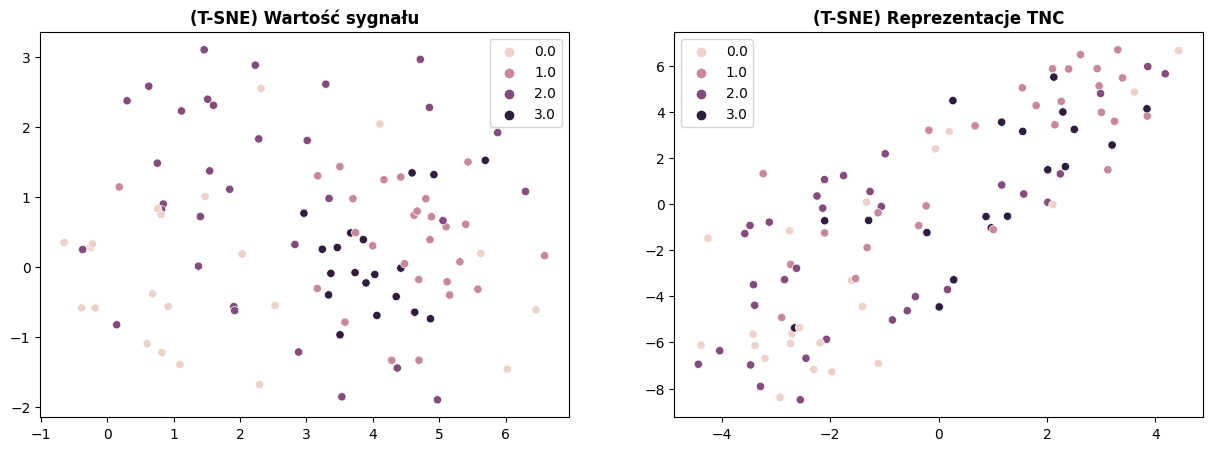

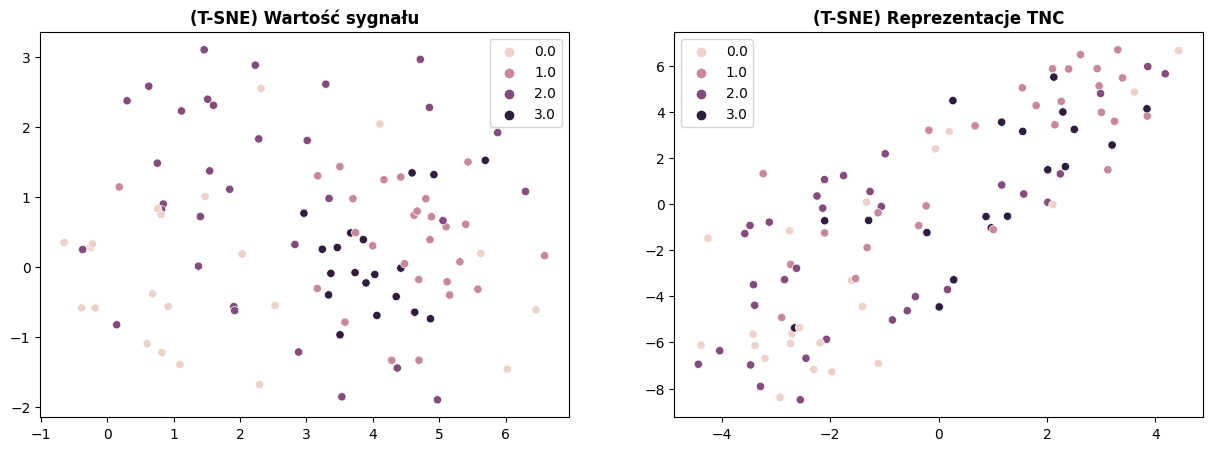

In [16]:
visualize(default_hparams["name"])

In [17]:
def evaluate_classification_clustering(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")
    
    metrics = evaluate_model(
        dataset=dataset,
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )
    
    return metrics

In [18]:
evaluate_classification_clustering(default_hparams["name"])

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'auc': {'train': 0.8220053918210144,
  'val': 0.7993286535940147,
  'test': 0.8223201616444719},
 'cluster': {'silhouette': 0.2559972, 'davies_bouldin': 1.21568061872951}}

## Zadanie 2.6. Badanie hiperparametrów metody TNC (3 pkt)
Korzystając z podanych funkcji `train()` oraz `evaluate_classification_clustering()` zbadaj następujące hiperparametry:
- `window_size` (zbadaj co najmniej 3 wartości)
- `w` (zbadaj co najmniej 3 wartości)

Jeśli uczenie modelu będzie zbyt czasochłonne można zredukować liczbę epok. Każdy z parametrów można zbadać osobno - nie ma potrzeby przeglądania ich przekroju. Analizy powinny być prowadzone na podstawie metryk: AUC (zbiór testowy) oraz metryki klasteryzacji (Silhouette oraz Davies-Bouldin). Utwórz tabelki, które podsumują wyniki eksperymentów. Skomentuj wyniki

In [19]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


def get_average_for_param(result: pd.DataFrame, param: str, score: str = "max_reward") -> pd.DataFrame:
    avg_scores = result.groupby(param)[score].mean()
    avg_scores_df = avg_scores.reset_index()
    avg_scores_df.columns = [param, score]
    return avg_scores_df

def plot_avg_scores(result: pd.DataFrame, param: str, score: str = "max_reward", ax: plt.Axes = None):
    avg_scores = get_average_for_param(result, param, score)
    avg_learning_time = get_average_for_param(result, param, "learning_time")

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax.set_xlabel(param.capitalize())
    ax.set_ylabel(score, color=color)
    ax.plot(avg_scores[param], avg_scores[score], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend([score], loc='upper left')

    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Learning Time", color=color)
    ax2.plot(avg_learning_time[param], avg_learning_time["learning_time"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(["Learning Time"], loc='upper right')

    ax.yaxis.set_major_formatter('{x:.2f}')
    ax2.yaxis.set_major_formatter('{x:.2f} s')

    if ax is None:
        fig.tight_layout()
        plt.title(f"{score} and Learning Time for Different {param.capitalize()} Values per Dataset")
        plt.show()


def plot_all_avg_scores(result: pd.DataFrame, params: list[str], score: str = "max_reward"):
    num_plots = len(params)
    num_cols = num_plots
    num_rows = 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6))
    axs = axs.flatten()

    for i, param in enumerate(params):
        ax = axs[i]
        plot_avg_scores(result, param, score, ax=ax)

    if num_plots < num_cols:
        for ax in axs[num_plots:]:
            ax.axis('off')

    fig.tight_layout()
    plt.show()
    

def unpack_result(result: dict) -> dict:
    return {
        'train_auc': result['auc']['train'],
        'val_auc': result['auc']['val'],
        'test_auc': result['auc']['test'],
        'silhouette': result['cluster']['silhouette'],
        'davies_bouldin': result['cluster']['davies_bouldin']
    }

In [20]:
default_hparams = {
    "in_dim": 3,
    "hidden_dim": 100,
    "emb_dim": 10,
    "window_size": 50,
    "mc_sample_size": 40,
    "w": 0.05,
    "num_epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "batch_size": 10,
    "name": "default",
}

test_hparams = default_hparams

window_sizes = [25, 50, 100]
ws = [0.01, 0.05, 0.1]

params = list(itertools.product(window_sizes, ws))

results_df = []
for i in tqdm(range(len(params)), total=len(params)):
    window_size, w = params[i]
    test_hparams["window_size"] = window_size
    test_hparams["w"] = w
    test_hparams["name"] = f"windows_size_{window_size}/w_{str(w).replace('.', '')}"
    
    start_time = time.time()
    train(test_hparams)
    end_time = time.time()
    
    raw_result = evaluate_classification_clustering(test_hparams["name"])
    result = unpack_result(raw_result)
    result['learning_time'] = end_time - start_time
    result['window_size'] = window_size
    result['w'] = w
    results_df.append(result)

results_df = pd.DataFrame(results_df)

  0%|          | 0/9 [00:00<?, ?it/s]

Global seed set to 42
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\Piotr Szuba\Desktop\Semestr 1\UczenieReprezentacji\Lab5\data\checkpoints\windows_size_25\w_001 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Python311\Lib\site-packages\pytorch_lightning\trainer

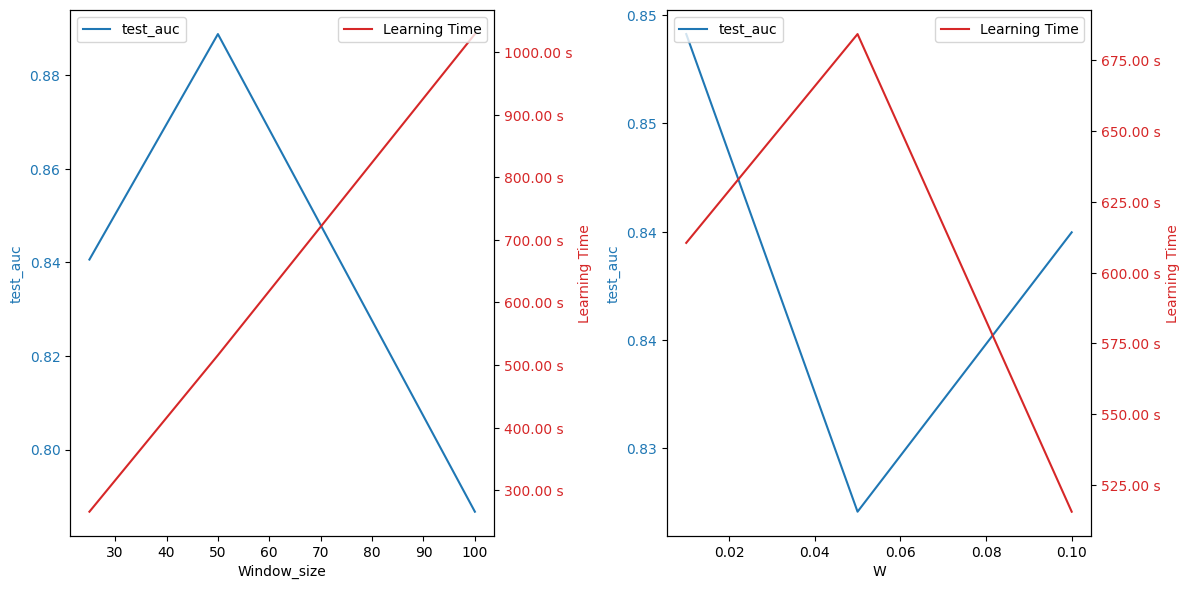

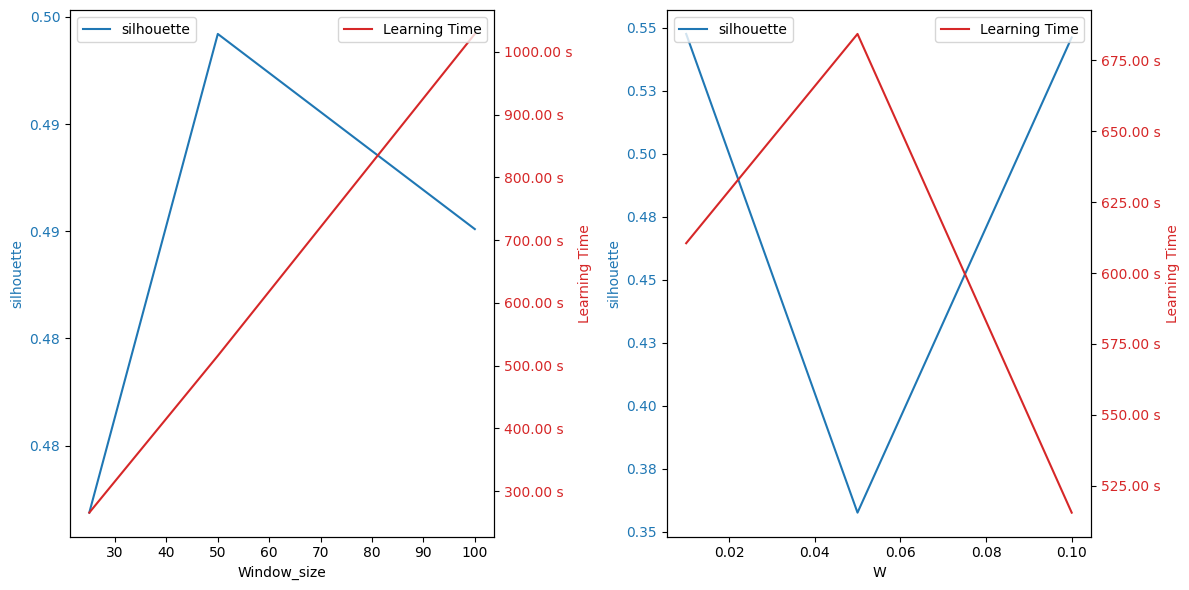

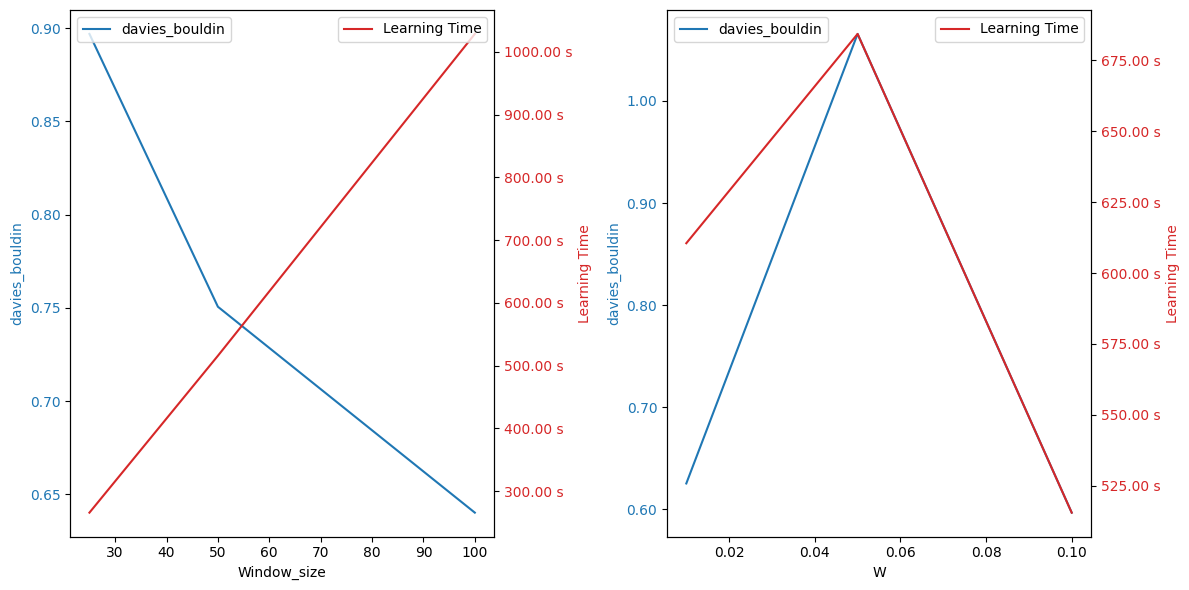

In [21]:
plot_all_avg_scores(results_df, ["window_size", "w"], "test_auc")
plot_all_avg_scores(results_df, ["window_size", "w"], "silhouette")
plot_all_avg_scores(results_df, ["window_size", "w"], "davies_bouldin")

Parametr window_size określa rozmiar okna przesuwnego, które jest używane do ekstrakcji próbek z szeregów czasowych. Wybór tego parametru wpływa na to, jak duże są okna czasu, które są porównywane ze sobą. Jeżeli okno jest zbyt małe, model może nie być w stanie uchwycić istotnych zależności czasowych. Z drugiej strony, zbyt duże okno może zawierać zbyt wiele informacji, które są nieistotne dla danego problemu.

Parametr w jest wagą w funkcji straty, która kontroluje wagę próbek nieoznaczonych. W kontekście modelu TNC, jest to ważne dla strategii Positive-Unlabeled (PU) learning, w której próbki spoza sąsiedztwa temporalnego są traktowane jako nieoznaczone. Wartość w ma wpływ na to, jak duży wpływ mają te próbki na końcową funkcję straty. Jeżeli w jest blisko 1, próbki spoza sąsiedztwa są traktowane prawie jak próbki pozytywne, a jeżeli w jest blisko 0, są one traktowane prawie jak próbki negatywne.

<h3>Parametr window_size</h3>

Widzimy, że AUC (obszar pod krzywą ROC) rośnie od window_size=25 do window_size=50, ale potem spada przy window_size=100. To sugeruje, że większe okno czasu umożliwia modelowi lepsze uchwycenie zależności w danych, ale tylko do pewnego momentu. Zbyt duże okno (window_size=100) prowadzi do pogorszenia wyników, co może wynikać z zaszywania istotnych informacji w szumie.

Indeks Silhouette i Davies-Bouldin również poprawiają się zwiększając window_size od 25 do 50, ale później pogarszają się przy window_size=100, co dodatkowo potwierdza powyższą obserwację.

Przy zwiększaniu wartości window_size od 25 do 100, czas treningu znacznie rośnie. To jest spodziewane, ponieważ większe okno czasu oznacza więcej danych do przetworzenia w każdym kroku, co zwiększa obciążenie obliczeniowe.

<h3>Parametr W</h3>

Dla parametru w nie widać jednoznacznej zależności między jego wartością a wynikami modelu. Wydaje się, że model osiąga lepsze wyniki AUC dla w=0.01 i w=0.1 niż dla w=0.05, co sugeruje, że wyższa waga próbek nieoznaczonych może nie zawsze prowadzić do lepszych wyników.

Indeks Silhouette jest najwyższy dla w=0.01 i w=0.1, co sugeruje, że te wartości prowadzą do lepszych klasterów. Davies-Bouldin jest najniższy dla w=0.1, co również wskazuje na lepsze klastrowanie.